In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")

In [290]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform, batch_size=50)

In [326]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
#         x = torch.softmax(self.fc1(x), 1)
#         x = torch.sigmoid(self.fc1(x))
#         x = self.fc1(x)
#         x = F.dropout(x, 0.5)
#         x = torch.relu(self.fc1(x))
        x = torch.tanh(self.fc1(x))
#         print(x.size())
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x

In [327]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_rho = h#.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        """
        D_KL(P||Q) = sum(p*log(p/q)) = -sum(p*log(q/p)) = -p*log(q/p) - (1-p)log((1-q)/(1-p))
        """
        
#         print(self.data_rho.size(), torch.argmax(self.data_rho, 1).size())
        
        input_ = torch.softmax(self.data_rho, 1)
#         dkl = input_.mean(0)*input_.mean(0)
#         print(input_)
        target_ = torch.argmax(input_, 1)
#         print(input_.size(), target_.size(), target_)
#         dkl = F.cross_entropy(input_, target_)
#         dkl = - torch.log(self.data_rho/rho) * rho - torch.log((1-self.data_rho)/(1-rho)) * (1-rho)

#         print(input_.mean(0).size())
#         dkl = - rho * torch.log(input_.mean(0)) - (1 - rho) * torch.log(1 - input_.mean(0))
#         maxInd = torch.argmax(self.data_rho)
#         print(maxInd, dkl)
    
#         maxInd = torch.argmax(self.data_rho)
#         dkl = self.data_rho
#         dkl[maxInd] = 0
#         print(maxInd, dkl)

#         print(self.data_rho, self.data_rho.size())
#         input_ = torch.softmax(self.data_rho.reshape(), 1)#.reshape([1, self.latent_size])
#         target_ = torch.argmax(input_).reshape([1])

        dkl = F.nll_loss(input_, target_)
    
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [328]:
models = {'16': Net(16).to(device), '32': Net(32).to(device), '64': Net(64).to(device)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [329]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data.to(device))
            rho_loss = model.rho_loss(rho, True)
            loss = model.loss(output, data.to(device)) #+ rho_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [330]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'rho_loss: {}'.format(p)
data_rho_lambda = lambda q: 'data_rho: {}'.format(q)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
line_extra = lambda i, l, p, q: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p) + '\n' + data_rho_lambda(q)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    rho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data.to(device)) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data.to(device), reduction='sum').item() # sum up batch loss
                rho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        rho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], rho_loss[k], models[k].data_rho))
    
    lines = '\n'.join([line(k, test_loss[k], rho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [332]:
for epoch in range(1, 101):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 0.282031 32: 0.253910 64: 0.195037
Train Epoch: 1 [10000/50000 (20%)]	Losses 16: 0.288656 32: 0.256425 64: 0.189823
Train Epoch: 1 [20000/50000 (40%)]	Losses 16: 0.270424 32: 0.234867 64: 0.168982
Train Epoch: 1 [30000/50000 (60%)]	Losses 16: 0.275039 32: 0.237908 64: 0.165666
Train Epoch: 1 [40000/50000 (80%)]	Losses 16: 0.277433 32: 0.232826 64: 0.166581
Train Epoch: 1 [50000/50000 (100%)]	Losses 16: 0.261166 32: 0.216872 64: 0.142936
Test set:
16: loss: 0.2613	rho_loss: -0.00017860507788136602
32: loss: 0.2136	rho_loss: -3.924594281706959e-05
64: loss: 0.1444	rho_loss: -1.035187541274354e-05

Train Epoch: 2 [0/50000 (0%)]	Losses 16: 0.255987 32: 0.206276 64: 0.135159
Train Epoch: 2 [10000/50000 (20%)]	Losses 16: 0.245672 32: 0.196928 64: 0.134424
Train Epoch: 2 [20000/50000 (40%)]	Losses 16: 0.245687 32: 0.188352 64: 0.124260
Train Epoch: 2 [30000/50000 (60%)]	Losses 16: 0.250421 32: 0.192772 64: 0.127617
Train Epoch: 2 [40000/50000 (80%)]	Lo

Train Epoch: 13 [50000/50000 (100%)]	Losses 16: 0.121437 32: 0.072654 64: 0.035365
Test set:
16: loss: 0.1192	rho_loss: -0.0001799347792752087
32: loss: 0.0718	rho_loss: -4.400910902768374e-05
64: loss: 0.0350	rho_loss: -1.129849287099205e-05

Train Epoch: 14 [0/50000 (0%)]	Losses 16: 0.113753 32: 0.063459 64: 0.030408
Train Epoch: 14 [10000/50000 (20%)]	Losses 16: 0.124079 32: 0.075257 64: 0.035462
Train Epoch: 14 [20000/50000 (40%)]	Losses 16: 0.108346 32: 0.063346 64: 0.031669
Train Epoch: 14 [30000/50000 (60%)]	Losses 16: 0.109652 32: 0.065280 64: 0.031082
Train Epoch: 14 [40000/50000 (80%)]	Losses 16: 0.117622 32: 0.070272 64: 0.033953
Train Epoch: 14 [50000/50000 (100%)]	Losses 16: 0.116345 32: 0.066909 64: 0.032816
Test set:
16: loss: 0.1161	rho_loss: -0.00017723686499521136
32: loss: 0.0692	rho_loss: -4.445591284893453e-05
64: loss: 0.0335	rho_loss: -1.1373849731171503e-05

Train Epoch: 15 [0/50000 (0%)]	Losses 16: 0.128950 32: 0.077487 64: 0.036020
Train Epoch: 15 [10000/50000

Train Epoch: 26 [10000/50000 (20%)]	Losses 16: 0.087895 32: 0.049745 64: 0.021441
Train Epoch: 26 [20000/50000 (40%)]	Losses 16: 0.097480 32: 0.052711 64: 0.023458
Train Epoch: 26 [30000/50000 (60%)]	Losses 16: 0.096872 32: 0.053997 64: 0.022863
Train Epoch: 26 [40000/50000 (80%)]	Losses 16: 0.098896 32: 0.055913 64: 0.022886
Train Epoch: 26 [50000/50000 (100%)]	Losses 16: 0.089827 32: 0.048339 64: 0.021484
Test set:
16: loss: 0.0984	rho_loss: -0.00016616573873907327
32: loss: 0.0548	rho_loss: -4.3776329886168243e-05
64: loss: 0.0244	rho_loss: -1.1975594674004241e-05

Train Epoch: 27 [0/50000 (0%)]	Losses 16: 0.095068 32: 0.052786 64: 0.022472
Train Epoch: 27 [10000/50000 (20%)]	Losses 16: 0.102872 32: 0.058099 64: 0.024303
Train Epoch: 27 [20000/50000 (40%)]	Losses 16: 0.090811 32: 0.051277 64: 0.022585
Train Epoch: 27 [30000/50000 (60%)]	Losses 16: 0.087460 32: 0.046153 64: 0.019848
Train Epoch: 27 [40000/50000 (80%)]	Losses 16: 0.103013 32: 0.057875 64: 0.024572
Train Epoch: 27 [500

Train Epoch: 38 [50000/50000 (100%)]	Losses 16: 0.088339 32: 0.047830 64: 0.019775
Test set:
16: loss: 0.0930	rho_loss: -0.00016059045577421785
32: loss: 0.0499	rho_loss: -4.178162442985922e-05
64: loss: 0.0213	rho_loss: -1.212347875116393e-05

Train Epoch: 39 [0/50000 (0%)]	Losses 16: 0.086659 32: 0.047026 64: 0.019247
Train Epoch: 39 [10000/50000 (20%)]	Losses 16: 0.097559 32: 0.052360 64: 0.023172
Train Epoch: 39 [20000/50000 (40%)]	Losses 16: 0.091654 32: 0.049158 64: 0.020780
Train Epoch: 39 [30000/50000 (60%)]	Losses 16: 0.091680 32: 0.049680 64: 0.019983
Train Epoch: 39 [40000/50000 (80%)]	Losses 16: 0.088791 32: 0.049390 64: 0.019532
Train Epoch: 39 [50000/50000 (100%)]	Losses 16: 0.092117 32: 0.046123 64: 0.019949
Test set:
16: loss: 0.0927	rho_loss: -0.00015988383358344436
32: loss: 0.0496	rho_loss: -4.155353326350451e-05
64: loss: 0.0211	rho_loss: -1.2185669166501611e-05

Train Epoch: 40 [0/50000 (0%)]	Losses 16: 0.091079 32: 0.051825 64: 0.021365
Train Epoch: 40 [10000/5000

Train Epoch: 51 [10000/50000 (20%)]	Losses 16: 0.097924 32: 0.052635 64: 0.022018
Train Epoch: 51 [20000/50000 (40%)]	Losses 16: 0.090206 32: 0.048663 64: 0.019184
Train Epoch: 51 [30000/50000 (60%)]	Losses 16: 0.095075 32: 0.051007 64: 0.020359
Train Epoch: 51 [40000/50000 (80%)]	Losses 16: 0.087110 32: 0.042688 64: 0.017697
Train Epoch: 51 [50000/50000 (100%)]	Losses 16: 0.080377 32: 0.040926 64: 0.017461
Test set:
16: loss: 0.0901	rho_loss: -0.0001563082435168326
32: loss: 0.0468	rho_loss: -4.077006080187857e-05
64: loss: 0.0197	rho_loss: -1.2182193924672901e-05

Train Epoch: 52 [0/50000 (0%)]	Losses 16: 0.096691 32: 0.050687 64: 0.020190
Train Epoch: 52 [10000/50000 (20%)]	Losses 16: 0.074607 32: 0.038190 64: 0.014870
Train Epoch: 52 [20000/50000 (40%)]	Losses 16: 0.096162 32: 0.051044 64: 0.021235
Train Epoch: 52 [30000/50000 (60%)]	Losses 16: 0.087563 32: 0.044795 64: 0.018062
Train Epoch: 52 [40000/50000 (80%)]	Losses 16: 0.084710 32: 0.043292 64: 0.017428
Train Epoch: 52 [50000

Train Epoch: 63 [50000/50000 (100%)]	Losses 16: 0.097534 32: 0.050062 64: 0.021466
Test set:
16: loss: 0.0887	rho_loss: -0.00015344873815774918
32: loss: 0.0452	rho_loss: -4.0082425076980146e-05
64: loss: 0.0187	rho_loss: -1.2152568256715312e-05

Train Epoch: 64 [0/50000 (0%)]	Losses 16: 0.090082 32: 0.048197 64: 0.019991
Train Epoch: 64 [10000/50000 (20%)]	Losses 16: 0.096354 32: 0.050436 64: 0.020110
Train Epoch: 64 [20000/50000 (40%)]	Losses 16: 0.101227 32: 0.051549 64: 0.020758
Train Epoch: 64 [30000/50000 (60%)]	Losses 16: 0.082265 32: 0.040704 64: 0.016464
Train Epoch: 64 [40000/50000 (80%)]	Losses 16: 0.084997 32: 0.042080 64: 0.016186
Train Epoch: 64 [50000/50000 (100%)]	Losses 16: 0.090017 32: 0.045391 64: 0.020438
Test set:
16: loss: 0.0884	rho_loss: -0.0001535501468926668
32: loss: 0.0451	rho_loss: -4.004956563003361e-05
64: loss: 0.0187	rho_loss: -1.2079476821236313e-05

Train Epoch: 65 [0/50000 (0%)]	Losses 16: 0.085269 32: 0.043724 64: 0.017041
Train Epoch: 65 [10000/500

Train Epoch: 76 [10000/50000 (20%)]	Losses 16: 0.092990 32: 0.047030 64: 0.020038
Train Epoch: 76 [20000/50000 (40%)]	Losses 16: 0.080669 32: 0.040358 64: 0.016136
Train Epoch: 76 [30000/50000 (60%)]	Losses 16: 0.081060 32: 0.038076 64: 0.015448
Train Epoch: 76 [40000/50000 (80%)]	Losses 16: 0.086807 32: 0.044996 64: 0.018788
Train Epoch: 76 [50000/50000 (100%)]	Losses 16: 0.087827 32: 0.045281 64: 0.018201
Test set:
16: loss: 0.0872	rho_loss: -0.0001510211289394647
32: loss: 0.0441	rho_loss: -3.940771357156336e-05
64: loss: 0.0181	rho_loss: -1.1863477632869035e-05

Train Epoch: 77 [0/50000 (0%)]	Losses 16: 0.085932 32: 0.043964 64: 0.018727
Train Epoch: 77 [10000/50000 (20%)]	Losses 16: 0.086035 32: 0.042818 64: 0.017223
Train Epoch: 77 [20000/50000 (40%)]	Losses 16: 0.083615 32: 0.042903 64: 0.017313
Train Epoch: 77 [30000/50000 (60%)]	Losses 16: 0.086008 32: 0.042130 64: 0.016169
Train Epoch: 77 [40000/50000 (80%)]	Losses 16: 0.080162 32: 0.041000 64: 0.017302
Train Epoch: 77 [50000

Train Epoch: 88 [50000/50000 (100%)]	Losses 16: 0.087132 32: 0.043693 64: 0.018319
Test set:
16: loss: 0.0865	rho_loss: -0.00014955955315381288
32: loss: 0.0430	rho_loss: -3.8939272495917975e-05
64: loss: 0.0177	rho_loss: -1.1600684997392819e-05

Train Epoch: 89 [0/50000 (0%)]	Losses 16: 0.082184 32: 0.040215 64: 0.017068
Train Epoch: 89 [10000/50000 (20%)]	Losses 16: 0.105000 32: 0.048401 64: 0.019291
Train Epoch: 89 [20000/50000 (40%)]	Losses 16: 0.080148 32: 0.039981 64: 0.016552
Train Epoch: 89 [30000/50000 (60%)]	Losses 16: 0.084950 32: 0.043389 64: 0.016604
Train Epoch: 89 [40000/50000 (80%)]	Losses 16: 0.078777 32: 0.040657 64: 0.016051
Train Epoch: 89 [50000/50000 (100%)]	Losses 16: 0.096497 32: 0.048472 64: 0.018540
Test set:
16: loss: 0.0865	rho_loss: -0.00014887107582762837
32: loss: 0.0430	rho_loss: -3.899242681218311e-05
64: loss: 0.0176	rho_loss: -1.1605664872331544e-05

Train Epoch: 90 [0/50000 (0%)]	Losses 16: 0.086031 32: 0.044492 64: 0.017807
Train Epoch: 90 [10000/50

In [339]:
mod = '64'
mod_ = int(mod)
data, _ = next(iter(test_loader))
output = models[mod](data.to(device))
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.cpu().numpy()
decoded = models[mod].decode(torch.eye(mod_).to(device))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()
with torch.no_grad():
    encoded = models[mod].E(data.view(-1, 28*28).to(device))
    print((torch.softmax(encoded, 1) > 0.02).sum(1))
    encoded[encoded < 0.5] = 0.
    decoded_f = models[mod].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.cpu().numpy()

tensor([14, 16, 13, 17, 11, 16, 18, 16, 19, 16, 19, 20, 14, 20, 13, 17, 18, 17,
        16, 16, 13, 12, 16, 15, 15, 19, 15, 16, 16, 16, 14, 18, 12, 15, 18, 16,
        15, 17, 16, 18, 14, 13, 15, 13, 16, 13, 16, 15, 17, 16])


torch.Size([50, 64])


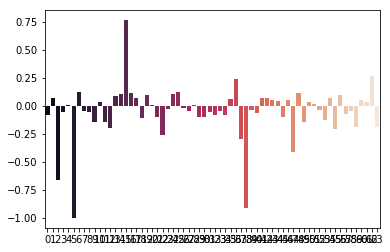

In [336]:
mod = '64'
mod_ = int(mod)
data, _ = next(iter(test_loader))
with torch.no_grad():
    encoded = models[mod].E(data.view(-1, 28*28).to(device))
    print(encoded.size())
    sns.barplot(np.arange(mod_), encoded.mean(0), palette="rocket")

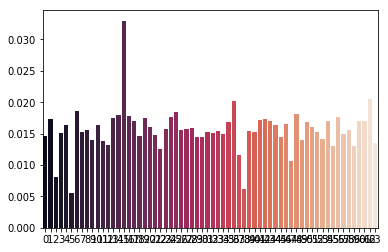

In [337]:
mod = '64'
mod_ = int(mod)
data, _ = next(iter(test_loader))
with torch.no_grad():
    encoded = models[mod].E(data.view(-1, 28*28).to(device))
    sns.barplot(np.arange(mod_), torch.softmax(encoded, 1).mean(0), palette="rocket")

In [ ]:
torch.argmax(torch.softmax(encoded, 1),1)
for i, ind in enumerate(torch.argmax(torch.softmax(encoded, 1),1)):
    print(i, ind, torch.softmax(encoded, 1)[i, ind])

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 20), sharex=True)
i = 99
sns.barplot(np.arange(16), test_log['16'][i][2].mean(0).cpu().numpy(), palette="rocket", ax=ax1)
sns.barplot(np.arange(32), test_log['32'][i][2].mean(0).cpu().numpy(), palette="rocket", ax=ax2)
sns.barplot(np.arange(64), test_log['64'][i][2].mean(0).cpu().numpy(), palette="rocket", ax=ax3)

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 20), sharex=True)
i = 99
sns.barplot(np.arange(16), torch.softmax(test_log['16'][i][2], 1).cpu().numpy().mean(0), palette="rocket", ax=ax1)
sns.barplot(np.arange(32), torch.softmax(test_log['32'][i][2], 1).cpu().numpy().mean(0), palette="rocket", ax=ax2)
sns.barplot(np.arange(64), torch.softmax(test_log['64'][i][2], 1).cpu().numpy().mean(0), palette="rocket", ax=ax3)

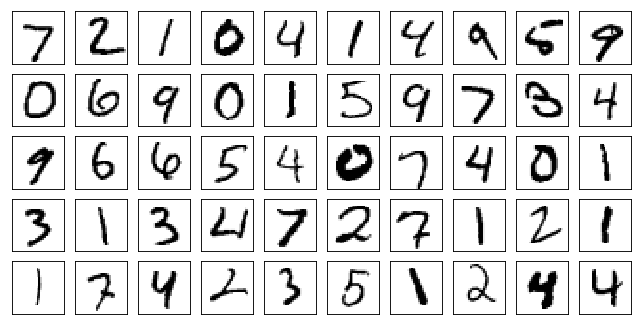

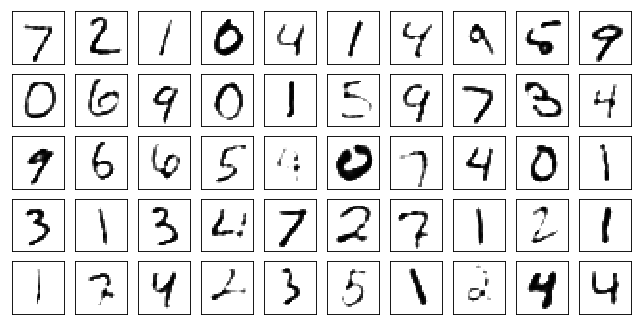

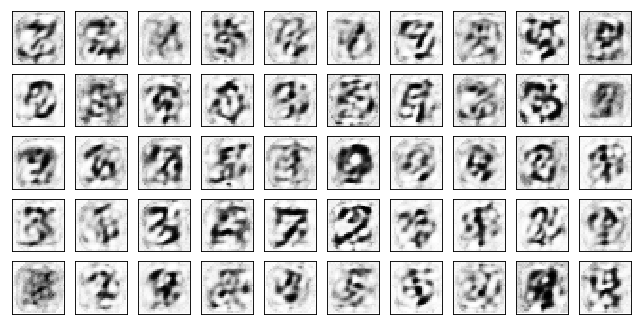

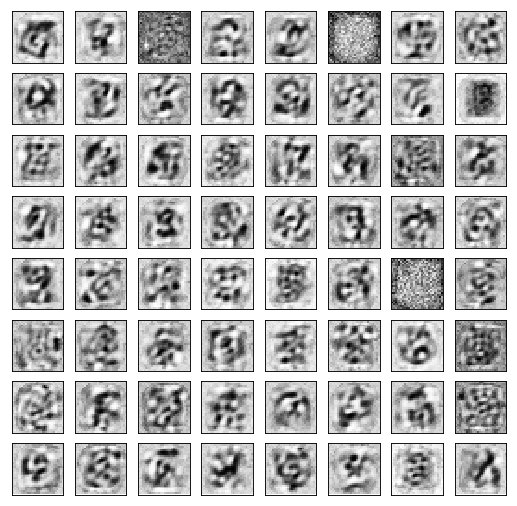

In [340]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(f_to_plot, (5, 10))
plot_mnist(dec_to_plot, (8, 8))